In [58]:
'''
Сайт "www.sravni.ru" публикует рейтинги банков России на основании отзывов пользователей. 
Возможно ли предсказать на основе ретроспективного анализа рейтинг конкретного банка на месяц вперед? 

Задачи: 
1. Собрать данные с сайта www.sravni.ru по банку "СовКомБанк" за несколько месяцев: 
дата отзыва, рейтинг, ответ банка на отзыв, статус решения проблемы.

2. Подготовить данные для анализа. 

3. Попробовать обучить модель линейной регрессии и оценить результат

'''
# Импорт модулей для начала работы: работа с датасетами и парсинг данных
import numpy as np
import pandas as pd
import requests as rq 
import time
from bs4 import BeautifulSoup as beautS
from requests_html import HTMLSession
import json

In [56]:
'''
Задача 1 - сбор данных с сайта https://www.sravni.ru/. Необходимо собрать данные отзывов пользователей: 
Дата отзыва; Рейтинг, выставленный пользователем; Ответ банка; Решена/не решена проблема, если таковая была

'''
df_infa = [] # Данные будут добавлятся в список, поэтому создается пустой список
for p in range(1, 400): # Количество страниц с отзывами на сайте необходимо перебрать через счетчик 
    time.sleep(3)
    url = f'https://www.sravni.ru/proxy-reviews/reviews?filterBy=withRates&fingerPrint=7553e7372907a64c8b8844df9c01e83d&isClient=false&locationRoute=&newIds=true&orderBy=byDate&pageIndex={p}&pageSize=10&reviewObjectId=5bb4f767245bc22a520a5fd5&reviewObjectType=bank&specificProductId=&tag=&withVotes=true'
    session = HTMLSession()
    links = session.get(url)
    page_10 = json.loads(links.html.html)
    # Страница с отзывами показана в виде словаря. Далее нужно собрать данные по требуемым ключам 
    page_11 = page_10.get('items', 0)
    for receive in page_11:
        X = [receive['rating'],receive['date'],receive['problemSolved'],receive['hasCompanyResponse']]
        # И добавить в список как вложенный список
        df_infa.append(X)
df_infa.append(df_infa)

In [ ]:
# Запись полученного списка в файл .csv
import csv
with open('receives1.csv', 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    for item in df_infa:
        csv_writer.writerow([item])

In [60]:
'''
Задача 2. Обработка данных перед проведением анализа. Загрузка файла как Датасета с обозначением колонок. 
'''
df=pd.read_csv("C:/Users/Ilia/Desktop/Python/infa.csv")
df.columns = ['Rate', 'Time', 'Solved', 'Answer']
df

,Rate,Time,Solved,Answer
0,[5,'2023-01-27T17:36:02.789152Z',False,False]
1,[5,'2023-01-27T13:29:46.915021Z',False,False]
2,[5,'2023-01-27T12:00:20.886354Z',False,False]
3,[5,'2023-01-27T09:54:59.132155Z',False,False]
4,[5,'2023-01-27T09:44:30.375147Z',False,False]
...,...,...,...,...
3974,[5,'2022-10-05T04:47:48.237571Z',False,True]
3975,[5,'2022-10-05T04:46:56.604264Z',False,True]
3976,[5,'2022-10-05T04:46:36.553169Z',False,True]
3977,[5,'2022-10-05T04:46:22.213838Z',False,True]


In [62]:
'''
Колонку "Rate" необходимо представить численно, 
колонку "Time" в формате Datatime, 
колонки Solved и Answer как 0 и 1 (целочисленно)

'''

for i in range(len(df)):
    if df.loc[i,'Answer'] == ' True]': df.loc[i,'Answer'] = int(1)
    else: df.loc[i,'Answer'] = int(0)
    df.loc[i,'Rate'] = int(df.loc[i,'Rate'].replace('[',''))
    if df.loc[i,'Solved'] == ' True': df.loc[i,'Solved'] = int(1)
    else: df.loc[i,'Solved'] = int(0)
    df.loc[i,'Time'] = pd.to_datetime(df.loc[i,'Time'][2:12])
    
'''Далее данные необходио агрегировать по дням: рейтинг средний за день, общее количество ответов и решений за день'''

df = df.groupby(['Time'], as_index = False).agg(
                RateDaily=('Rate', 'mean'), 
                SolvedDaily=('Solved', 'sum'), 
                AnswerDaily=('Answer', 'sum')
)

# Сохранить подготовленный датасет в файл
df.to_csv('dataset.csv')

In [24]:
df

,Time,RateDaily,SolvedDaily,AnswerDaily
0,2022-10-05,4.937951,0,693
1,2022-10-06,4.831461,1,89
2,2022-10-07,4.964286,0,56
3,2022-10-08,4.975000,0,40
4,2022-10-09,4.892857,0,28
...,...,...,...,...
110,2023-01-23,4.961538,0,1
111,2023-01-24,4.878788,0,3
112,2023-01-25,5.000000,0,0
113,2023-01-26,4.850000,0,4


In [63]:
df.dtypes

Time           datetime64[ns]
RateDaily             float64
SolvedDaily            object
AnswerDaily            object
dtype: object

In [25]:
df.shape

(115, 4)

In [27]:
# Для визуализации зависимости рейтинга от времени формирую формат оси времени
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d') 

<AxesSubplot:xlabel='Time'>

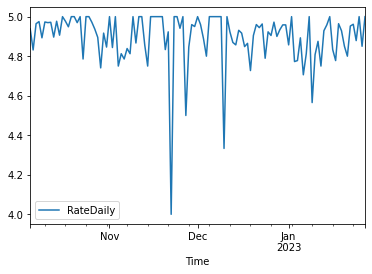

In [28]:
# График зависимости. Хаотичная зависимость 
df.plot('Time', 'RateDaily')

<AxesSubplot:xlabel='Time'>

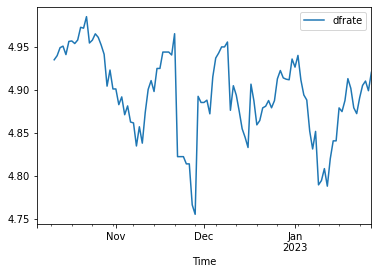

In [88]:
# Локальное усреднение значения функции. Ширина локального окна подбиралась по количеству дней недели. 
df['dfrate'] = df.RateDaily.rolling(7).mean()
df.plot('Time', 'dfrate')

In [89]:
# В датасет были включены пустые значения рейтинга за счет усреднения 
df['dfrate'] = df['dfrate'].fillna(0)
df.head(20)

,Time,RateDaily,SolvedDaily,AnswerDaily,dfrate
0,2022-10-05,4.937951,0,693,0.000000
1,2022-10-06,4.831461,1,89,0.000000
2,2022-10-07,4.964286,0,56,0.000000
3,2022-10-08,4.975000,0,40,0.000000
4,2022-10-09,4.892857,0,28,0.000000
5,2022-10-10,4.972973,0,37,0.000000
6,2022-10-11,4.969697,0,33,4.934889
7,2022-10-12,4.971429,0,35,4.939672
8,2022-10-13,4.896552,0,29,4.948970
9,2022-10-14,4.976744,0,43,4.950750


In [73]:
# Для деления датасета на обучающий и тестовый необходимо из обучающего удалить строки с пустыми значениями
df_train = df[6:-15]
df_test = df[-15:]

In [74]:
df_train

,Time,RateDaily,SolvedDaily,AnswerDaily,dfrate
6,2022-10-11,4.969697,0,33,4.934889
7,2022-10-12,4.971429,0,35,4.939672
8,2022-10-13,4.896552,0,29,4.948970
9,2022-10-14,4.976744,0,43,4.950750
10,2022-10-15,4.906250,0,32,4.940929
...,...,...,...,...,...
95,2023-01-08,5.000000,0,27,4.851678
96,2023-01-09,4.565217,1,23,4.789566
97,2023-01-10,4.807692,0,26,4.794561
98,2023-01-11,4.875000,0,32,4.808450


In [36]:
df_train.shape

(100, 5)

In [37]:
df_test.shape

(15, 5)

In [75]:
# Подготовка данных для обучения и проверки 
X_train = df_train.drop(['RateDaily', 'Time'], axis=1)
y_train = df_train['RateDaily']
X_test = df_test.drop(['RateDaily', 'Time'], axis=1)
y_test = df_test['RateDaily']

In [76]:
X_train.head()

,SolvedDaily,AnswerDaily,dfrate
6,0,33,4.934889
7,0,35,4.939672
8,0,29,4.948970
9,0,43,4.950750
10,0,32,4.940929


In [77]:
y_train.head(20)

6     4.969697
7     4.971429
8     4.896552
9     4.976744
10    4.906250
11    5.000000
12    4.976744
13    4.948718
14    5.000000
15    5.000000
16    4.969697
17    5.000000
18    4.785714
19    5.000000
20    5.000000
21    4.971429
22    4.936893
23    4.895105
24    4.740741
25    4.916667
Name: RateDaily, dtype: float64

In [78]:
X_train.isnull().mean() # проверка допустимых для обучения значений 

SolvedDaily    0.0
AnswerDaily    0.0
dfrate         0.0
dtype: float64

In [79]:
# Задача 3. Обучение модели 
lr = LinearRegression()
model = lr.fit(X_train, y_train)

In [80]:
print(lr.intercept_)
print(lr.coef_)

-0.667631921216012
[-1.20514318e-01  4.71748166e-04  1.13499138e+00]


In [81]:
prediction = lr.predict(X_test) # Предсказание на тестовом множестве

In [82]:
print('Actual values:', list(y_test.values))
print('Predictions:', prediction)

Actual values: [4.928571428571429, 4.958333333333333, 5.0, 4.833333333333333, 4.777777777777778, 4.964285714285714, 4.928571428571429, 4.85, 4.8, 4.9523809523809526, 4.961538461538462, 4.878787878787879, 5.0, 4.85, 5.0]
Predictions: [4.81607029 4.83735721 4.83499846 4.8841322  4.87362083 4.89281524
 4.91516463 4.90525542 4.87722425 4.87233371 4.88368614 4.90100758
 4.9053831  4.8945304  4.92168213]


In [83]:
prediction

array([4.81607029, 4.83735721, 4.83499846, 4.8841322 , 4.87362083,
       4.89281524, 4.91516463, 4.90525542, 4.87722425, 4.87233371,
       4.88368614, 4.90100758, 4.9053831 , 4.8945304 , 4.92168213])

In [99]:
df_test 

,Time,RateDaily,SolvedDaily,AnswerDaily,dfrate
100,2023-01-13,4.928571,0,28,4.819854
101,2023-01-14,4.958333,0,23,4.840688
102,2023-01-15,5.000000,0,18,4.840688
103,2023-01-16,4.833333,0,30,4.878990
104,2023-01-17,4.777778,0,18,4.874717
105,2023-01-18,4.964286,0,28,4.887472
106,2023-01-19,4.928571,0,14,4.912982
107,2023-01-20,4.850000,0,20,4.901757
108,2023-01-21,4.800000,0,15,4.879138
109,2023-01-22,4.952381,0,21,4.872336


In [85]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [86]:
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(list(y_test.values), prediction))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(list(y_test.values), prediction))

Mean squared error: 0.01
Coefficient of determination: -0.41


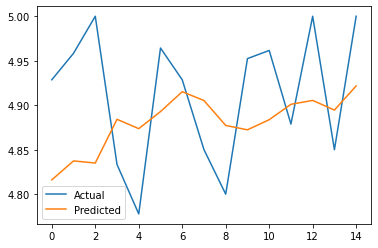

In [87]:
'''
Сравнение результатов предсказаний с реальными данными
''' 
plt.plot(list(y_test.values), label='Actual')
plt.plot(prediction, label='Predicted')
plt.legend()

In [13]:
from sklearn.metrics import mean_absolute_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt

In [14]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import plotly.express as go

In [94]:
# Расширение датасета на месяц вперед
from datetime import timedelta
TimeLr = timedelta(days=31)
Time_1 = pd.date_range(df['Time'][114], df['Time'][114]+TimeLr)
Time_Lr = pd.DataFrame(Time_1)
print(TimeLr)
Time_Lr

31 days, 0:00:00


,0
0,2023-01-27
1,2023-01-28
2,2023-01-29
3,2023-01-30
4,2023-01-31
5,2023-02-01
6,2023-02-02
7,2023-02-03
8,2023-02-04
9,2023-02-05
